In [1]:
# import numpy as np
# df=np.load("../CSI-02-0005/H_32T4R_30_1RB.npy")
# data=df.reshape(2100,398,256)
# data.shape
# feature_len=data.shape[-1]

import scipy.io
import numpy as np

# Load the .mat file
file_path = '../EV_Rank_1_52_RBs_50_UEs_1000_snaps.mat'
data = scipy.io.loadmat(file_path)
# Extract the relevant data
data = data['EV_re_im_split']

feature_len=832
# Inspect the structure of the loaded data
# data.keys()
feature_len

832

In [2]:
data.shape

(50, 1000, 832)

In [3]:
data=data[0]

In [4]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
data = data.reshape(data.shape[0], -1)  # shape becomes (2100, 398*256)


In [6]:
data.shape

(1000, 832)

In [7]:
import numpy as np

# Load your dataset if it's not already loaded
# data = np.load('path/to/your/data.npy')

# Set up parameters
num_UEs, num_timesteps = data.shape
sequence_length = 10  # Use the first 10 values as input
stride = 1  # Moving one step at a time

# Initialize lists to hold input and output sequences
X, y = [], []

# Loop through each UE
for ue_idx in range(num_UEs):
    ue_data = data[ue_idx]
    num_sequences = (num_timesteps - sequence_length) // stride

    # Extract input sequences
    input_indices = np.arange(sequence_length) + np.arange(num_sequences)[:, None]
    input_seq = ue_data[input_indices]

    # Extract output values
    output_indices = np.arange(sequence_length, num_sequences + sequence_length)
    output_value = ue_data[output_indices]

    # Append to the lists
    X.append(input_seq)
    y.append(output_value)

# Convert lists to NumPy arrays for easier processing
X = np.concatenate(X)
y = np.concatenate(y)

print(f"Input shape: {X.shape}")
print(f"Output shape: {y.shape}")


Input shape: (822000, 10)
Output shape: (822000,)


In [8]:
# Define the train-test split ratio (e.g., 80% train, 20% test)
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

# Split the data into training and testing while keeping the time series intact
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the resulting shapes
print(f"Training data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

Training data shapes: X_train: (657600, 10), y_train: (657600,)
Testing data shapes: X_test: (164400, 10), y_test: (164400,)


In [9]:
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout, Add, Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Simplified TCN residual block
def residual_block(x, dilation_rate, num_filters, kernel_size, dropout_rate=0.0):
    conv1 = Conv1D(num_filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    act1 = ReLU()(bn1)
    drop1 = Dropout(dropout_rate)(act1)

    # Removed second convolutional layer and its components

    if x.shape[-1] != num_filters:
        x = Conv1D(num_filters, kernel_size=1)(x)

    out = Add()([x, drop1])
    out = ReLU()(out)
    return out

# Build simplified TCN model
def build_tcn_model(input_shape, num_blocks=2, num_filters=32, kernel_size=3, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    x = inputs

    for i in range(num_blocks):
        dilation_rate = 2 ** i
        x = residual_block(x, dilation_rate, num_filters, kernel_size, dropout_rate)

    x = Flatten()(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Example usage
input_length = 10  # The number of previous time steps used for input
num_features = 1  # Modify according to your dataset

# Adjust `num_features` if your input sequences contain multiple features.
model = build_tcn_model(input_shape=(input_length, num_features))

model.summary()

model.save('best_tcn_model.keras')


2024-05-24 12:31:32.020217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 12:31:33.813707: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 12:31:33.829102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-24 12:31:3

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 32)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 10, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 32)    │         64 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 32)    │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 32)    │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 10, 32)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 32)    │      3,104 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 32)    │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 10, 32)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 32)    │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 32)    │          0 │ re_lu_1[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 10, 32)    │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 320)       │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        321 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,873 (15.13 KB)

 Trainable params: 3,745 (14.63 KB)

 Non-trainable params: 128 (512.00 B)

In [10]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming you have `X_train`, `y_train`, `X_test`, and `y_test` arrays loaded from preprocessing
# Make sure the input data is reshaped to have the expected dimensions (num_samples, sequence_length, num_features)

# Reshape input to have the required dimensions: (samples, input_length, num_features)
num_features = 1  # Adjust based on the dataset (e.g., 1 for univariate, multiple if needed)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], num_features))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], num_features))

# Initialize the TCN model
model = build_tcn_model(input_shape=(X_train.shape[1], num_features))

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_tcn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=5,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/5


I0000 00:00:1716534095.844012   15039 service.cc:145] XLA service 0x71ddb800c840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716534095.844059   15039 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-24 12:31:35.896238: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-24 12:31:36.106118: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   69/20550 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 1.1584

I0000 00:00:1716534100.161771   15039 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20550/20550 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - loss: 0.0435 - val_loss: 0.0032
Epoch 2/5
20550/20550 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 3/5
20550/20550 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 4/5
20550/20550 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 5/5
20550/20550 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.0031 - val_loss: 0.0027


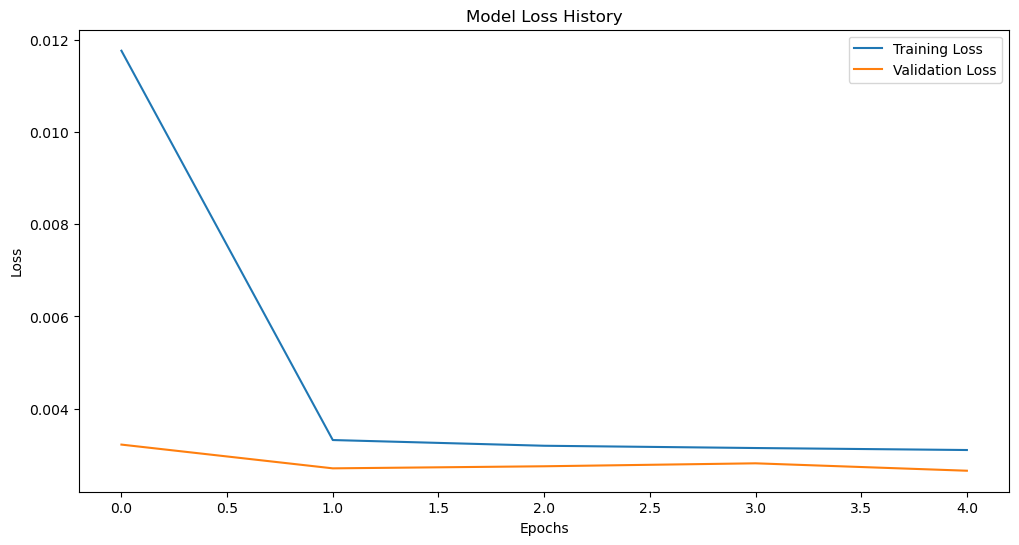

In [11]:
# Check the training history for loss/accuracy improvement
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss History')
plt.show()


In [15]:
type(history)

keras.src.callbacks.history.History